In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')

In [3]:
df.groupby(['mes','ano'], observed=False).agg({'partos_e_nascimentos_qtd': 'sum'}).reset_index()

mes   ano  partos_e_nascimentos_qtd
0      1  2009                  105424.0
1      1  2010                  103943.0
2      1  2011                   98951.0
3      1  2012                   92914.0
4      1  2013                   94223.0
..   ...   ...                       ...
177   12  2019                   80365.0
178   12  2020                   75730.0
179   12  2021                   78142.0
180   12  2022                   75175.0
181   12  2023                   64281.0

[182 rows x 3 columns]

In [4]:
df['data'] = list(map(lambda x,y: "{}-{}".format(x,y), df['ano'], df['mes']))

In [5]:
def convert_to_datetime(data):
    return datetime.strptime(data, format("%Y-%m"))

In [6]:
df['time'] = list(map(lambda x: convert_to_datetime(x), df['data']))

In [7]:
df_st = df.groupby(['time']).agg({'partos_e_nascimentos_qtd': 'sum',
                                  'partos_e_nascimentos_val':'sum',
                                  'cirurgias_obstetricas_qtd': 'sum',
                                  'cirurgias_obstetricas_val': 'sum'})

In [8]:
df_st.head()

partos_e_nascimentos_qtd  partos_e_nascimentos_val  \
time                                                             
2009-01-01                  105424.0               56176411.81   
2009-02-01                  102933.0               54825506.19   
2009-03-01                  117114.0               62399264.22   
2009-04-01                  113382.0               60340947.92   
2009-05-01                  114401.0               61212225.34   

            cirurgias_obstetricas_qtd  cirurgias_obstetricas_val  
time                                                              
2009-01-01                    70826.0                34960984.60  
2009-02-01                    69128.0                34439919.89  
2009-03-01                    77726.0                38846455.60  
2009-04-01                    75718.0                37832404.45  
2009-05-01                    76650.0                38719927.20

In [9]:
df_st = df_st['2009-01-01':'2023-12-01']

In [10]:
df_st.shape

(180, 4)

In [11]:
df_st.isnull().sum()

partos_e_nascimentos_qtd     0
partos_e_nascimentos_val     0
cirurgias_obstetricas_qtd    0
cirurgias_obstetricas_val    0
dtype: int64

In [12]:
fig = px.line(df_st, y='partos_e_nascimentos_qtd',title='Números de partos entre 2009 e 2023')
# fig2 = px.line(df_st, y='partos_e_nascimentos_val',title='Valores com partos entre 2009 e 2024')
#fig = make_subplots(rows=2, cols=1, subplot_titles=('Quantidade', 'Valores'), shared_xaxes=True, shared_yaxes=False)

#fig.add_trace(go.Scatter(x=df_st.index, y=df_st['partos_e_nascimentos_qtd'], mode='lines', name='Quantidade'), row=1, col=1)
#fig.add_trace(go.Scatter(x=df_st.index, y=df_st['partos_e_nascimentos_val'], mode='lines', name='Valores'), row=2, col=1)

#fig.update_xaxes(dtick="M1", tickmode='auto', rangeslider_visible=True)
fig.update_layout(template = 'plotly_white')

# fig.update_layout(
#     xaxis2_rangeslider_visible=True,
#     xaxis2_type="date",
#     autosize=True, height=900
#     )
fig.show()

In [13]:
df_st

partos_e_nascimentos_qtd  partos_e_nascimentos_val  \
time                                                             
2009-01-01                  105424.0               56176411.81   
2009-02-01                  102933.0               54825506.19   
2009-03-01                  117114.0               62399264.22   
2009-04-01                  113382.0               60340947.92   
2009-05-01                  114401.0               61212225.34   
...                              ...                       ...   
2023-08-01                   72737.0               42330404.13   
2023-09-01                   69596.0               40402950.86   
2023-10-01                   67911.0               39509933.76   
2023-11-01                   66166.0               38674158.57   
2023-12-01                   64281.0               37576476.97   

            cirurgias_obstetricas_qtd  cirurgias_obstetricas_val  
time                                                              
2009-01-01                    70826.0                34960984.60  
2009-02-01                    69128.0                34439919.89  
2009-03-01                    77726.0                38846455.60  
2009-04-01                    75718.0                37832404.45  
2009-05-01                    76650.0                38719927.20  
...                               ...                        ...  
2023-08-01                    92820.0                51477761.33  
2023-09-01                    89545.0                49211171.90  
2023-10-01                    88512.0                48678007.20  
2023-11-01                    86385.0                47615551.26  
2023-12-01                    84110.0                46159764.70  

[180 rows x 4 columns]

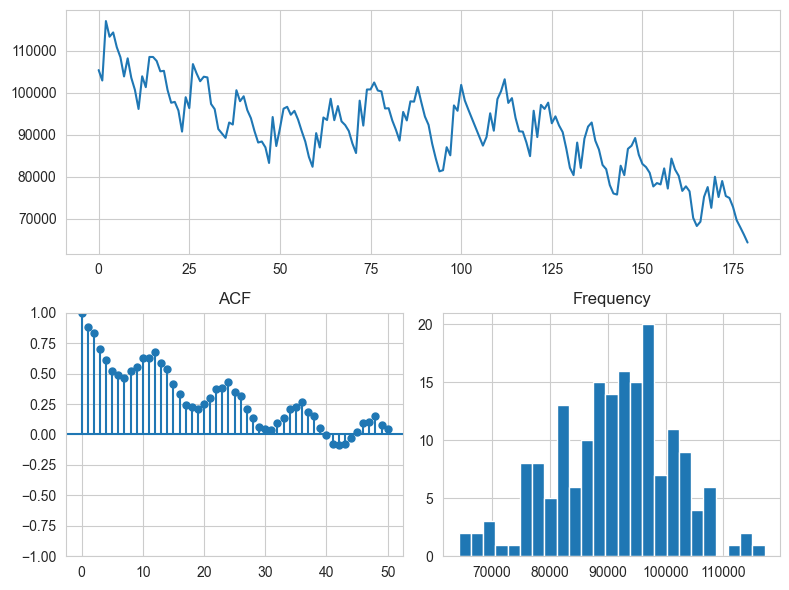

In [149]:
tsdisplay(df_st['partos_e_nascimentos_qtd'])

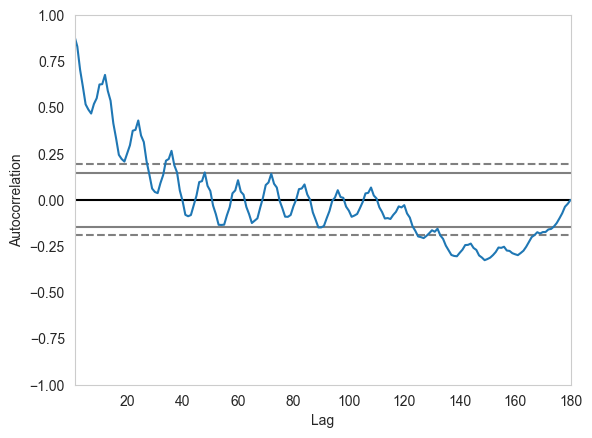

In [150]:
autocorr_plot(df_st['partos_e_nascimentos_qtd'])

In [148]:
stepwise=auto_arima(df_st['partos_e_nascimentos_qtd'],
                    start_p=0,
                    start_q=0,
                    d=None, test='adf',
                    max_p=6,
                    max_q=6,
                    #max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=2,
                    max_P=3, max_Q=3, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,2,1)[12]             : AIC=3173.401, Time=1.17 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=3183.670, Time=0.03 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=3072.267, Time=0.17 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=3138.394, Time=0.24 sec
 ARIMA(1,0,0)(0,2,0)[12]             : AIC=3157.391, Time=0.05 sec
 ARIMA(1,0,0)(2,2,0)[12]             : AIC=3043.602, Time=0.46 sec
 ARIMA(1,0,0)(3,2,0)[12]             : AIC=3014.603, Time=1.06 sec
 ARIMA(1,0,0)(3,2,1)[12]             : AIC=inf, Time=3.05 sec
 ARIMA(1,0,0)(2,2,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(3,2,0)[12]             : AIC=3184.564, Time=0.84 sec
 ARIMA(2,0,0)(3,2,0)[12]             : AIC=3009.518, Time=1.23 sec
 ARIMA(2,0,0)(2,2,0)[12]             : AIC=3037.625, Time=0.54 sec
 ARIMA(2,0,0)(3,2,1)[12]             : AIC=2988.316, Time=2.19 sec
 ARIMA(2,0,0)(2,2,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(2,0,0)(3,2,2)[12]          

In [149]:
print(stepwise.aic())
print(stepwise.bic())

2980.025863884699
3004.4247119426955


In [89]:
# treino e test
df_st_treino = df_st.loc[:'2022-12-01']['partos_e_nascimentos_qtd']
df_st_teste = df_st.loc['2023-01-01':]['partos_e_nascimentos_qtd']

In [90]:
df_st_treino.shape

(168,)

In [91]:
df_st_teste.shape

(12,)

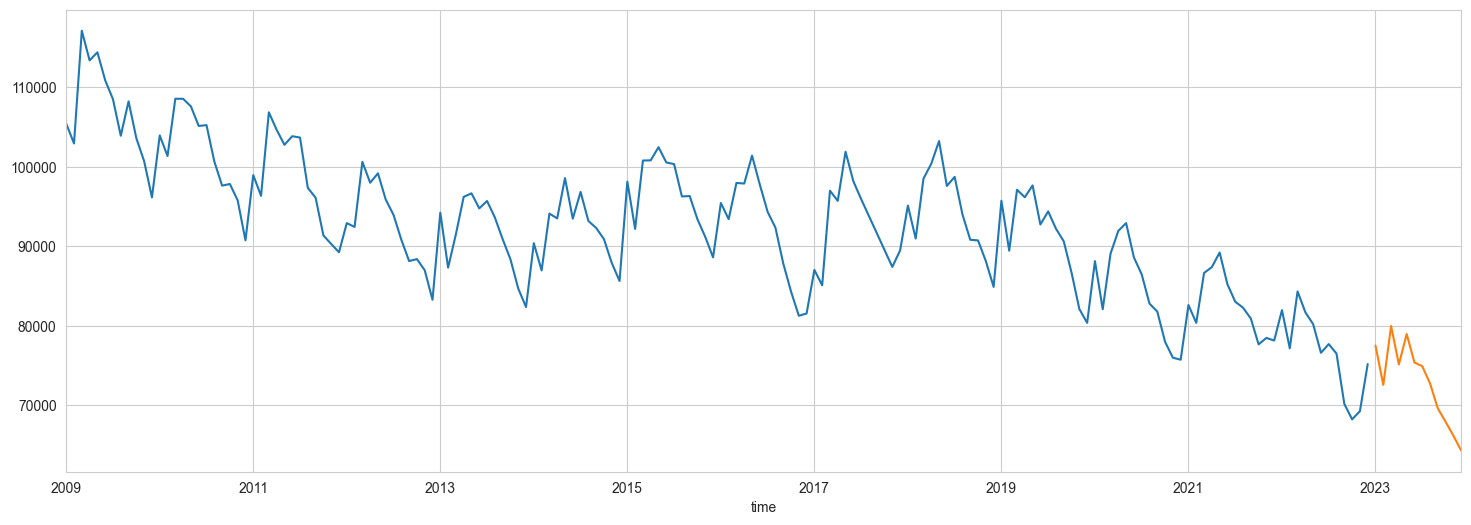

In [92]:
fig, ax=plt.subplots(figsize=(18, 6))
df_st_treino.plot(ax=ax, label='train')
df_st_teste.plot(ax=ax, label='test')
plt.show()


In [150]:
stepwise.fit(df_st_treino)

ARIMA(order=(4, 0, 0), scoring_args={}, seasonal_order=(2, 2, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [151]:
previsao = stepwise.predict(n_periods=12)

In [152]:
previsao = pd.DataFrame(previsao,
                      index=df_st_teste.index,
                      columns=['previsao_modelo_1'])

In [153]:
previsao

previsao_modelo_1
time                         
2023-01-01       76620.719100
2023-02-01       71699.447235
2023-03-01       80371.630381
2023-04-01       76801.643619
2023-05-01       75000.585039
2023-06-01       71736.277053
2023-07-01       72854.550441
2023-08-01       72014.739210
2023-09-01       65171.557508
2023-10-01       63261.572589
2023-11-01       64836.575385
2023-12-01       71787.374372

<Figure size 2000x500 with 0 Axes>

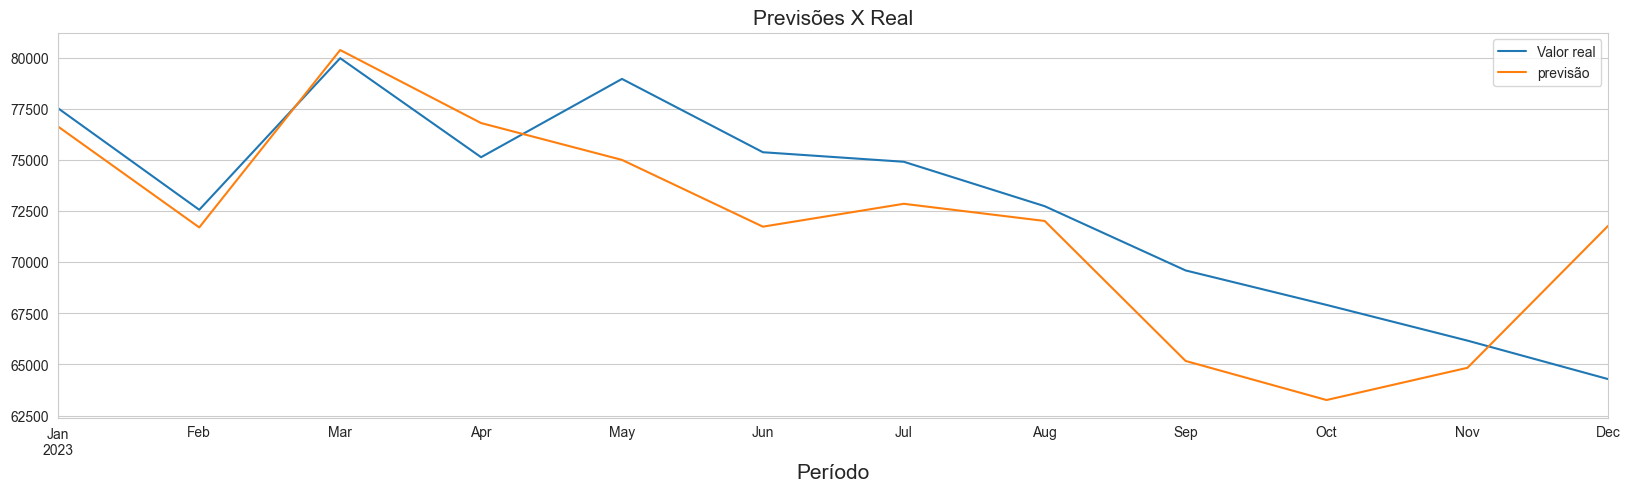

In [154]:
plt.figure(figsize=(20,5))
pd.concat([df_st_teste, previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão'])
plt.show()

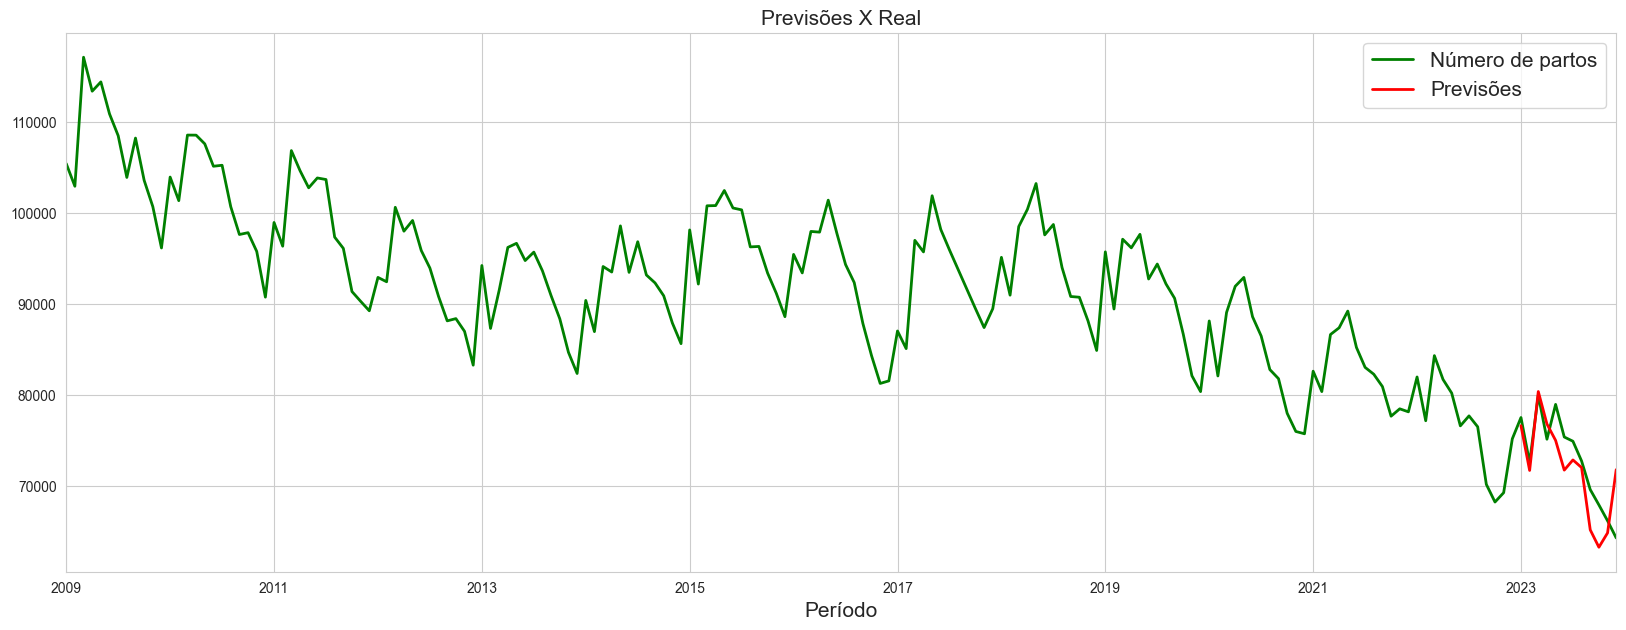

In [155]:
pd.concat([df_st.partos_e_nascimentos_qtd, previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Número de partos','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();

In [156]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(4, 0, 0)x(2, 2, [1], 12)   Log Likelihood               -1361.638
Date:                              Thu, 20 Jun 2024   AIC                           2739.277
Time:                                      17:11:11   BIC                           2763.035
Sample:                                  01-01-2009   HQIC                          2748.931
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6264      0.198      3.167      0.002       0.239       1.014
ar.L2          0.2200      0.176      1.247      0.212      -0.126       0.566
ar.L3          0.2912      0.201      1.448      0.148      -0.103       0.685
ar.L4         -0.1679      0.179     -0.935      0.350      -0.520       0.184
ar.S.L12      -0.0286      0.072     -0.400      0.689      -0.169       0.112
ar.S.L24      -0.0037      0.065     -0.058      0.954      -0.131       0.123
ma.S.L12      -0.8412      0.152     -5.539      0.000      -1.139      -0.544
sigma2      1.549e+07   4.24e-09   3.65e+15      0.000    1.55e+07    1.55e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.76   Prob(JB):                         0.70
Heteroskedasticity (H):               0.80   Skew:                            -0.09
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+31. Standard errors may be unstable.
"""

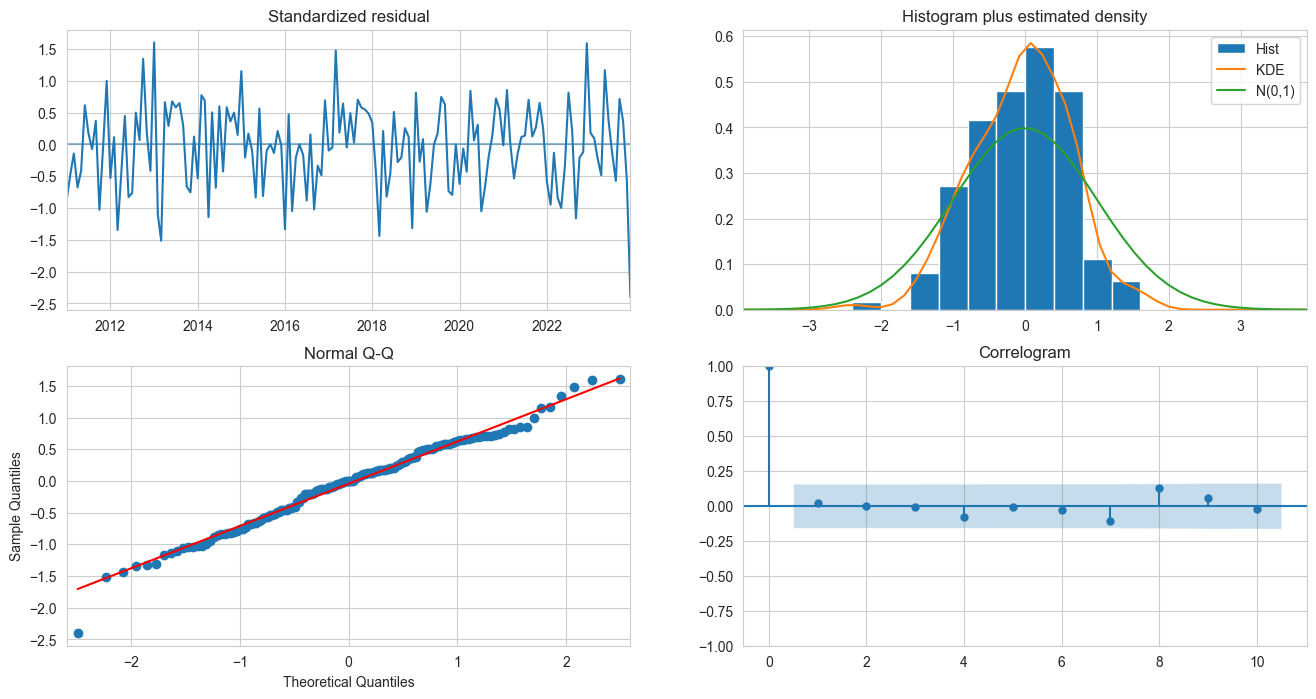

In [205]:
stepwise.plot_diagnostics(figsize=(16,8))
plt.show()

In [203]:
future = stepwise.predict(n_periods=12)

In [202]:
future = pd.DataFrame(future, index=df_st_teste.index, columns=['previsao'])

In [204]:
future

2024-01-01    69394.983321
2024-02-01    64306.403128
2024-03-01    70558.983934
2024-04-01    66287.636541
2024-05-01    70297.059185
2024-06-01    66536.665820
2024-07-01    66479.498149
2024-08-01    64473.883989
2024-09-01    61125.793982
2024-10-01    59688.079455
2024-11-01    58142.624911
2024-12-01    56455.111294
Freq: MS, dtype: float64

In [206]:
from sklearn.metrics import mean_squared_error

print("RMSE do modelo: %.3f" % np.sqrt(mean_squared_error(df_st_teste, future)))

RMSE do modelo: 8457.643


In [207]:
stepwise.fit(df_st.partos_e_nascimentos_qtd)

ARIMA(order=(4, 0, 0), scoring_args={}, seasonal_order=(2, 2, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [181]:
future_forecast=stepwise.predict(n_periods=6)

In [182]:
future_forecast=pd.DataFrame(future_forecast, 
                              index=pd.date_range(start='2024-01-01',
                                                  end='2024-06-01', freq='MS'),columns=['nova previsão'])

In [183]:
future_forecast.tail()

nova previsão
2024-02-01   64306.403128
2024-03-01   70558.983934
2024-04-01   66287.636541
2024-05-01   70297.059185
2024-06-01   66536.665820

<Figure size 2000x500 with 0 Axes>

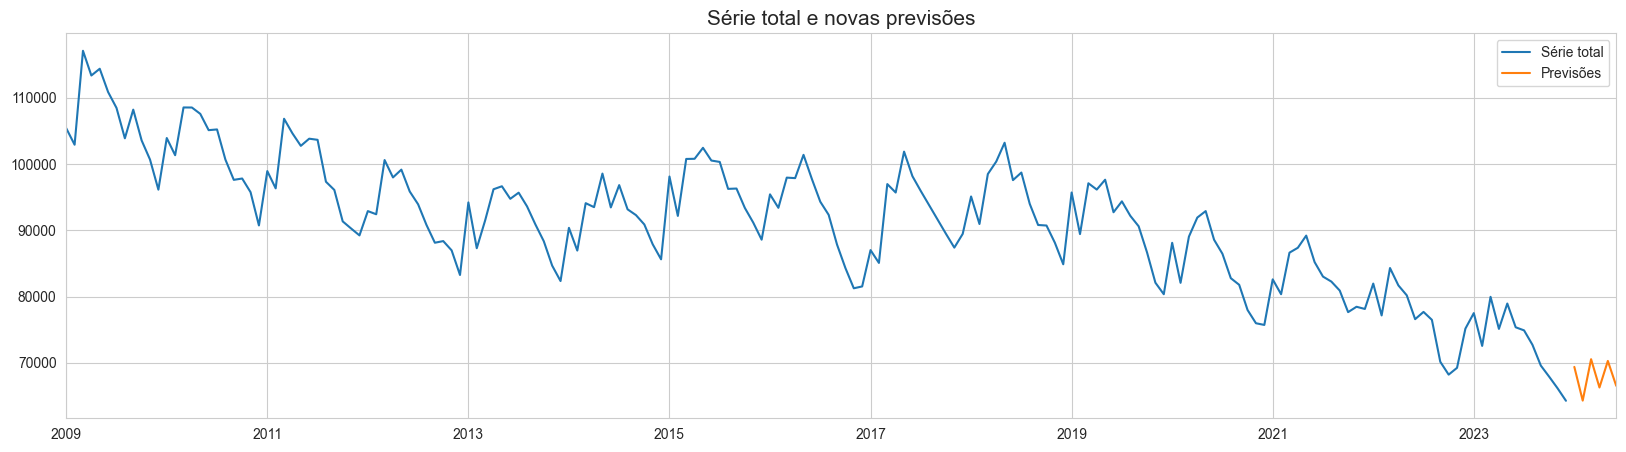

In [184]:
plt.figure(figsize=(20,5))
pd.concat([df_st.partos_e_nascimentos_qtd,future_forecast],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e novas previsões',size=15)
plt.legend(['Série total','Previsões'])
plt.show();

In [ ]:
# fim

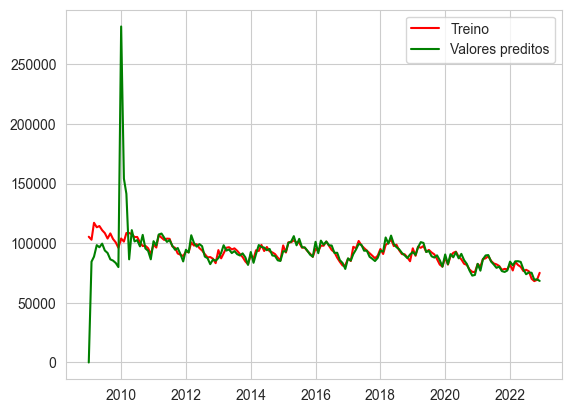

In [185]:
modelo = SARIMAX(df_st_treino, order=(4, 0, 0), seasonal_order=(2, 2, 1, 12)).fit(disp=0)

predito = modelo.predict(typ='levels')
plt.plot(df_st_treino, color='red')
plt.plot(predito,color='green')
plt.legend(['Treino','Valores preditos']);

In [274]:
predito

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=168, freq='MS')

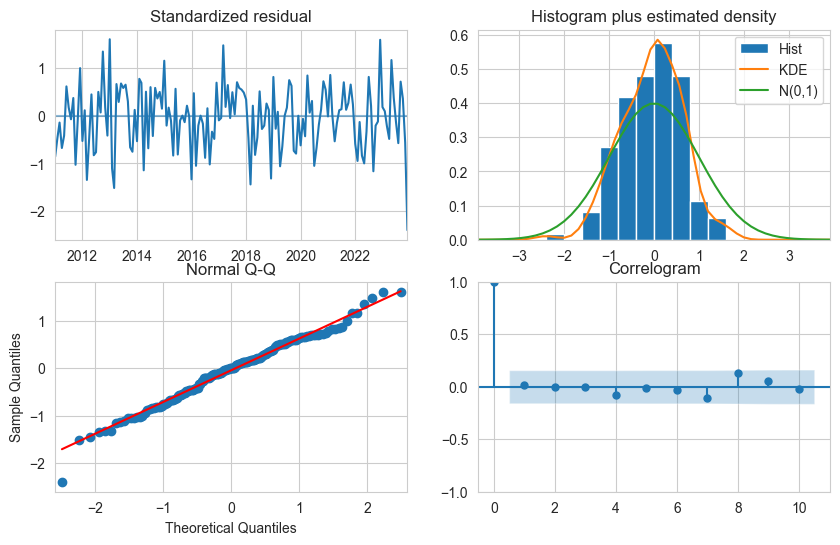

In [168]:
stepwise.plot_diagnostics(figsize=(10,6))
plt.show()

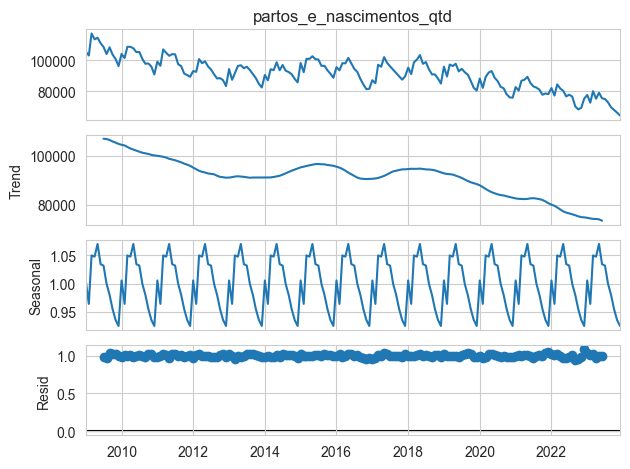

In [194]:
decomposition = seasonal_decompose(df_st['partos_e_nascimentos_qtd'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

In [199]:
df_st['not_sazon'] = df_st['partos_e_nascimentos_qtd']/decomposition.seasonal

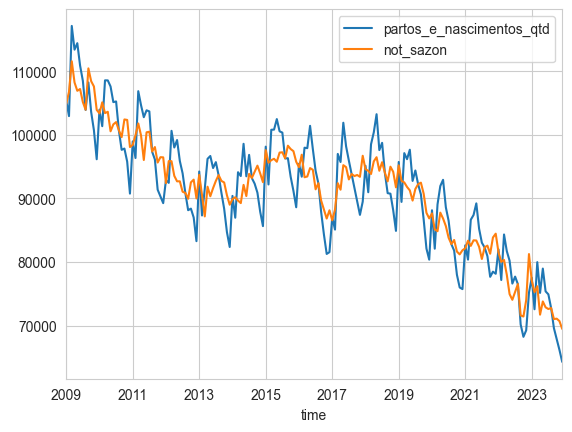

In [202]:
df_st[['partos_e_nascimentos_qtd', 'not_sazon']].plot()
plt.show()

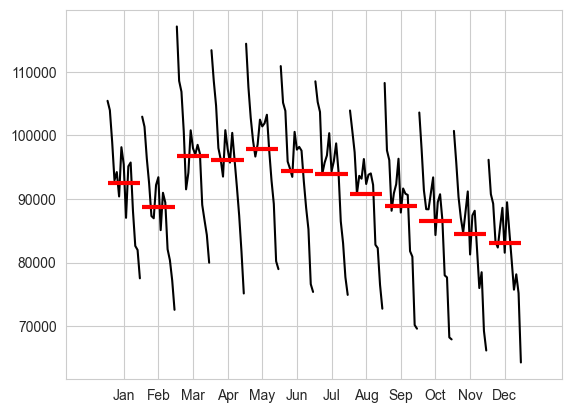

In [205]:
month_plot(df_st['partos_e_nascimentos_qtd'])
plt.show()

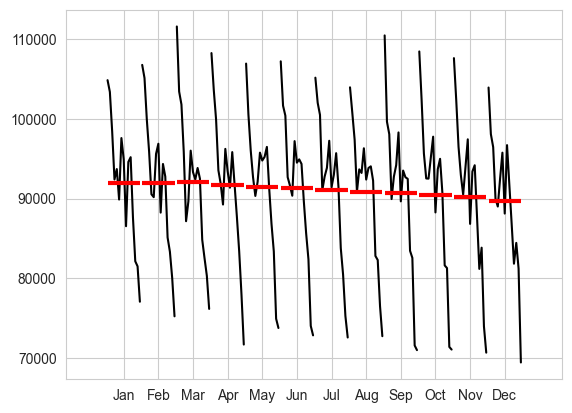

In [207]:
month_plot(df_st['not_sazon'])
plt.show()

In [85]:
df_st['media_movel'] = df_st['partos_e_nascimentos_qtd'].rolling(window=12).mean()
df_st['desvio_padrao'] = df_st['partos_e_nascimentos_qtd'].rolling(window=12).std()

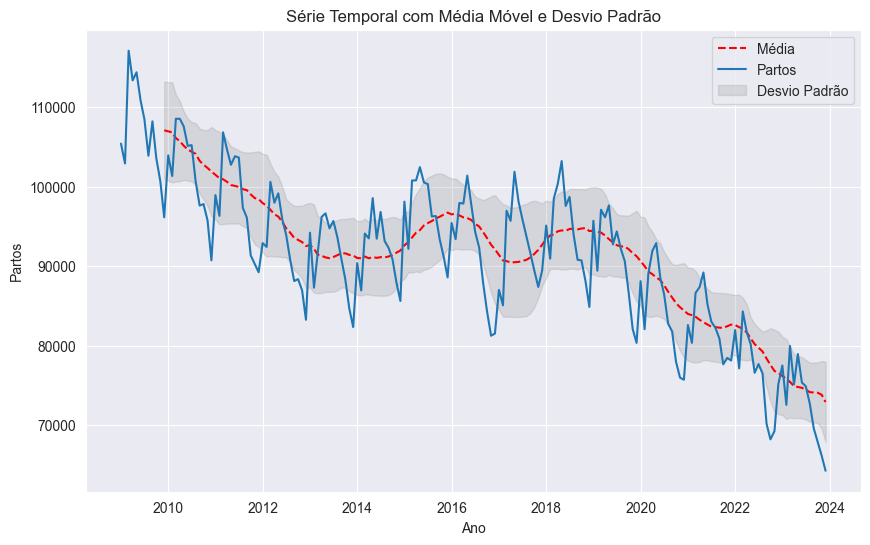

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(df_st.index, df_st.media_movel, color='r', linestyle='--', label='Média')
plt.plot(df_st.index, df_st.partos_e_nascimentos_qtd, label='Partos')

plt.fill_between(df_st.index, 
                 df_st['media_movel'] - df_st['desvio_padrao'], 
                 df_st['media_movel'] + df_st['desvio_padrao'], 
                 color='gray', alpha=0.2, label='Desvio Padrão')
plt.title('Série Temporal com Média Móvel e Desvio Padrão')
plt.xlabel('Ano')
plt.ylabel('Partos')
plt.legend()
plt.grid(True)
plt.show()

## Teste Dickey-Fuller
Hipótese nula - Ho:  a série é não estacionária.

Hipótese alternativa - Ha: a série é estacionária.

Teste ADF na série original:
ADF Statistic: -1.6354969740033178
p-value: 0.4646147103367285
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
ADF Statistic: -1.6354969740033178
p-value: 0.4646147103367285
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
1


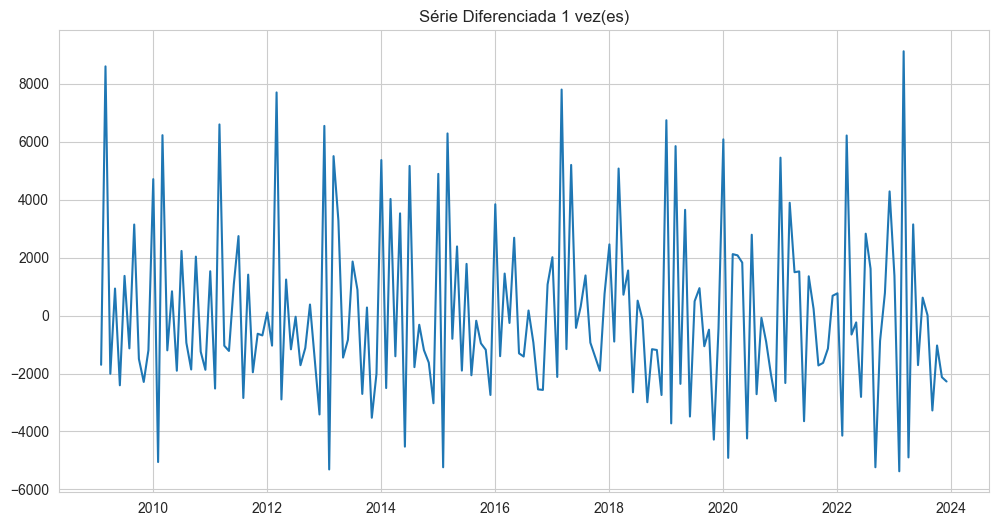

ADF Statistic: -2.6767852182255165
p-value: 0.0781423078169548
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
2


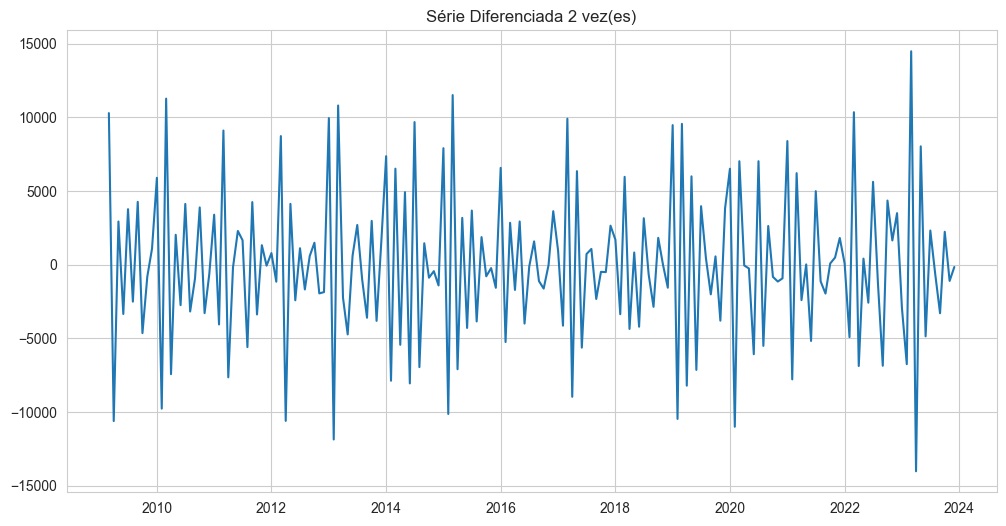

ADF Statistic: -9.726841688698231
p-value: 9.225770795444533e-17
Critical Values:
   1%: -3.470616369591229
   5%: -2.8792214018977655
   10%: -2.57619681359045
A série se tornou estacionária após 2 diferenciações.


In [16]:
# Função para testar estacionariedade com o teste ADF
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05  # Retorna True se a série é estacionária (p-value <= 0.05)

# # Plotar a série temporal original
# plt.figure(figsize=(12, 6))
# plt.plot(df_st.index, df_st['partos_e_nascimentos_qtd'])
# plt.title('Nascimentos Anuais')
# plt.show()

# Testar estacionariedade da série original
print('Teste ADF na série original:')
adf_test(df_st['cirurgias_obstetricas_qtd'])

# Diferenciação até a série se tornar estacionária
d = 0
serie = df_st['cirurgias_obstetricas_qtd']
while not adf_test(serie):
    d += 1
    print(d)
    serie = serie.diff().dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(serie)
    plt.title(f'Série Diferenciada {d} vez(es)')
    plt.show()

print(f'A série se tornou estacionária após {d} diferenciações.')


In [210]:
from statsmodels.tsa.statespace.tools import diff

In [211]:
df_st_no_sazon_diff = diff(df_st.not_sazon, k_diff=1)

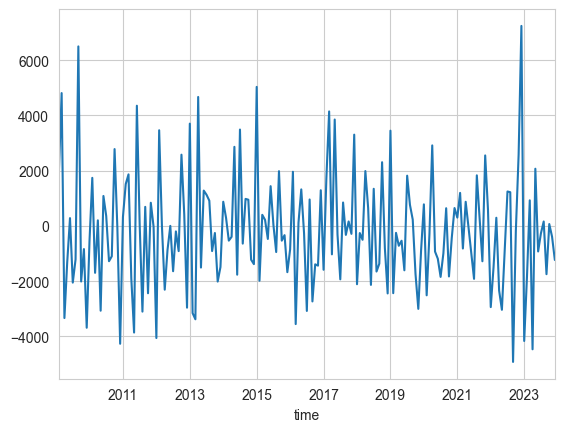

In [212]:
df_st_no_sazon_diff.plot()
plt.show()

In [213]:
print('Estatística do teste Dickey-Fuller:',adfuller(df_st_no_sazon_diff)[0])
print('P-valor:',adfuller(df_st_no_sazon_diff)[1])
print('Defasagens usadas no teste:',adfuller(df_st_no_sazon_diff)[2])
print('Observações usadas:',adfuller(df_st_no_sazon_diff)[3])
print('Valores críticos:',adfuller(df_st_no_sazon_diff)[4])

Estatística do teste Dickey-Fuller: -14.236853646404649
P-valor: 1.5618862408487662e-26
Defasagens usadas no teste: 1
Observações usadas: 177
Valores críticos: {'1%': -3.467845319799907, '5%': -2.878011745497439, '10%': -2.575551186759871}


In [17]:
SARIMA_model = auto_arima(df_st['partos_e_nascimentos_qtd'], start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=12,
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5, 
                         seasonal=True,
                         d=2, 
                         D=2,
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [18]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  180
Model:             SARIMAX(4, 2, 0)x(4, 2, [1], 12)   Log Likelihood               -1456.295
Date:                              Thu, 20 Jun 2024   AIC                           2932.591
Time:                                      12:51:07   BIC                           2962.960
Sample:                                  01-01-2009   HQIC                          2944.927
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9133      0.080    -11.437      0.000      -1.070      -0.757
ar.L2         -0.6481      0.102     -6.373      0.000      -0.847      -0.449
ar.L3         -0.2563      0.110     -2.322      0.020      -0.473      -0.040
ar.L4         -0.1246      0.090     -1.385      0.166      -0.301       0.052
ar.S.L12      -0.2930      0.074     -3.959      0.000      -0.438      -0.148
ar.S.L24      -0.1549      0.060     -2.586      0.010      -0.272      -0.037
ar.S.L36      -0.1394      0.049     -2.822      0.005      -0.236      -0.043
ar.S.L48      -0.0439      0.034     -1.305      0.192      -0.110       0.022
ma.S.L12      -0.8504      0.088     -9.662      0.000      -1.023      -0.678
sigma2      9.089e+06   5.75e-09   1.58e+15      0.000    9.09e+06    9.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.31   Prob(JB):                         0.81
Heteroskedasticity (H):               0.72   Skew:                             0.11
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+31. Standard errors may be unstable.
"""

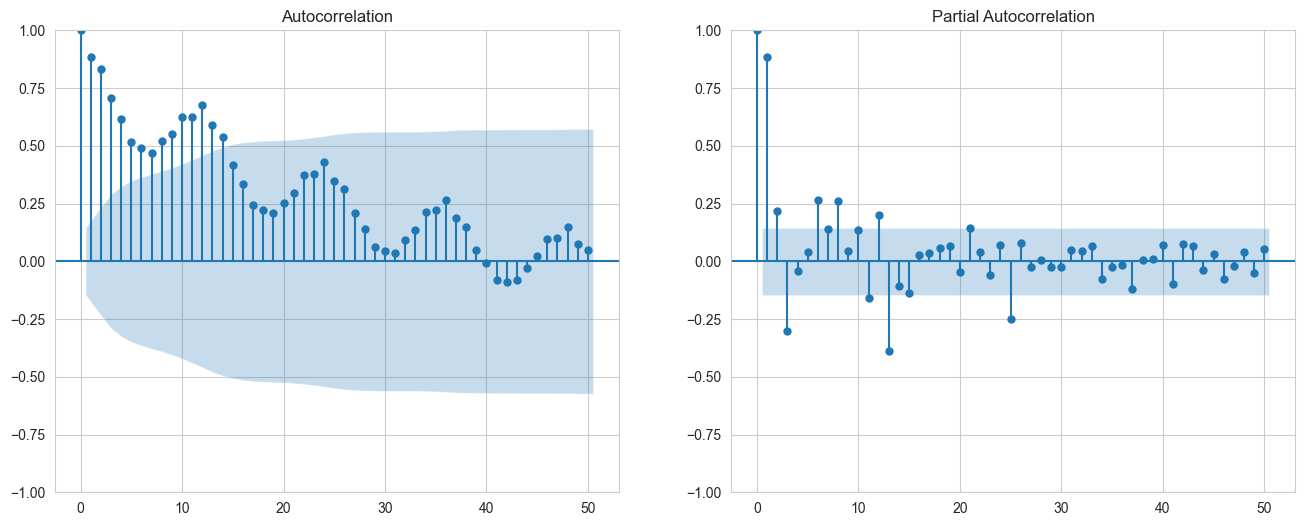

In [284]:
# Plotar ACF e PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_st.partos_e_nascimentos_qtd, lags=50, ax=ax[0])
plot_pacf(df_st.partos_e_nascimentos_qtd, lags=50, ax=ax[1])
plt.show()

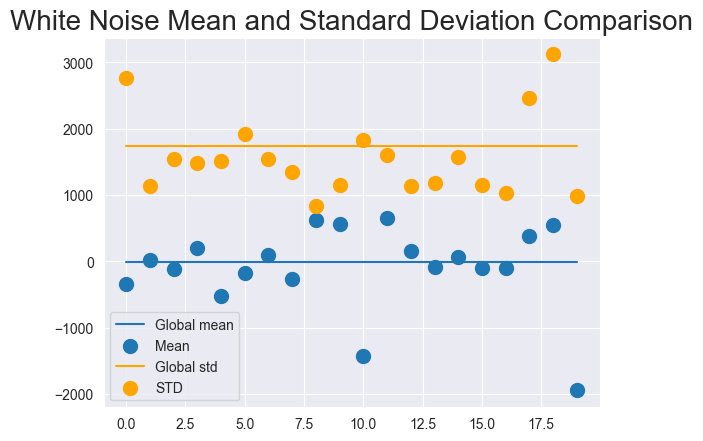

In [129]:
# Ruído Branco
white_noise_chunks = np.split(decomposition.resid, 20)
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [df_st['partos_e_nascimentos_qtd'].mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [decomposition.resid.std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend()

In [19]:
from statsmodels.tsa.ar_model import AutoReg

In [25]:
ar_one = AutoReg(df.partos_e_nascimentos_qtd, lags=24, missing='drop').fit()

In [26]:
print(ar_one.aic)

5303241.736932586


In [15]:
# Usar auto_arima para encontrar os melhores valores de p, d e q
model = pm.auto_arima(df_st['partos_e_nascimentos_qtd'], seasonal=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3457.038, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3505.685, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3501.437, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3503.454, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3504.203, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3478.250, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3477.614, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3477.501, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3453.809, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3476.896, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3476.273, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3452.430, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3501.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : 

                                  SARIMAX Results                                   
Dep. Variable:     partos_e_nascimentos_qtd   No. Observations:                  180
Model:                       ARIMA(3, 2, 3)   Log Likelihood               -1751.330
Date:                      Wed, 12 Jun 2024   AIC                           3516.661
Time:                              14:21:20   BIC                           3538.933
Sample:                          01-01-2009   HQIC                          3525.693
                               - 12-01-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5378      0.180     -2.984      0.003      -0.891      -0.185
ar.L2          0.6446      0.115      5.602      0.000       0.419       0.870
ar.L

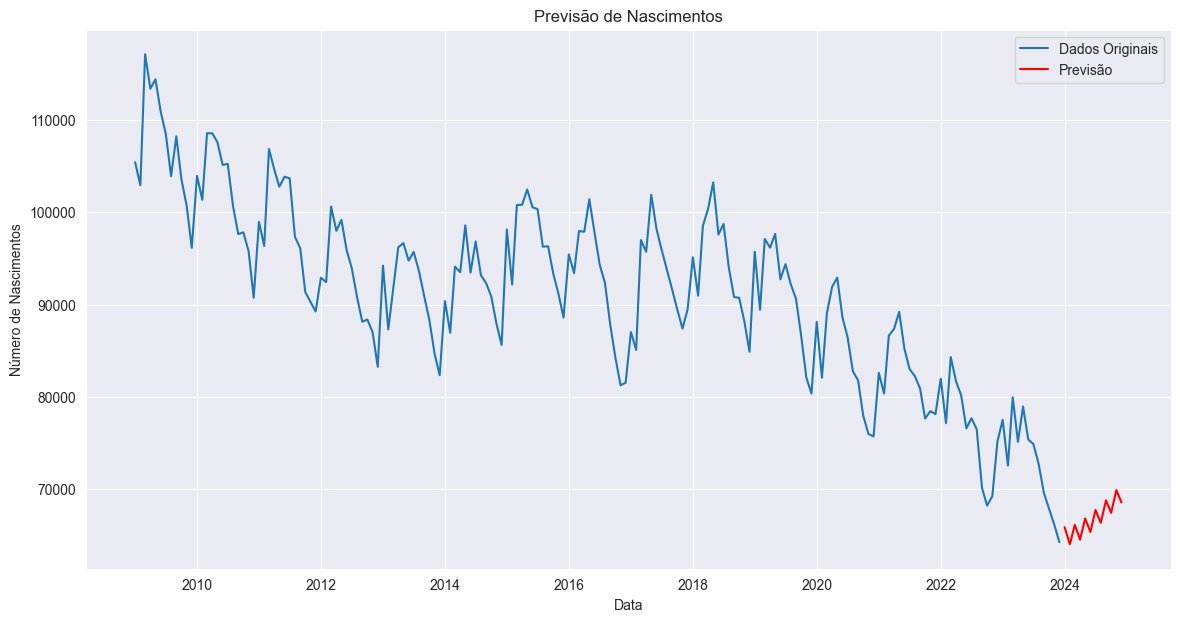

In [18]:
model = ARIMA(df_st['partos_e_nascimentos_qtd'], order=(3, 2, 3))
model_fit = model.fit()
print(model_fit.summary())

# Previsão
forecast = model_fit.forecast(steps=12)
plt.figure(figsize=(14, 7))
plt.plot(df_st.index, df_st['partos_e_nascimentos_qtd'], label='Dados Originais')
plt.plot(forecast.index, forecast, label='Previsão', color='red')
plt.title('Previsão de Nascimentos')
plt.xlabel('Data')
plt.ylabel('Número de Nascimentos')
plt.legend()
plt.show()


In [ ]:
# select tap."Nome_Municipio", tap.ano, sum(tap.qtd_0310) as qtd_partos from tb_aih_parto tap
# group by tap.ano, tap."Nome_Municipio"
# order by tap."Nome_Municipio"

In [138]:
df = pd.read_csv('dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')

In [167]:
df_gb = df.groupby(['ano', 'municipio'])['partos_e_nascimentos_qtd'].sum().reset_index()

In [255]:
df_agrupado_ano_municipio = df_gb.query('partos_e_nascimentos_qtd > 0')[['ano', 'municipio']]

In [256]:
df_agrupado_ano_municipio.query('municipio=="Adustina"')

ano municipio
68892  2022  Adustina
74189  2023  Adustina
79486  2024  Adustina

In [195]:
df_para_mediana = df.query('ano in @df_agrupado_ano_municipio["ano"] and municipio in @df_agrupado_ano_municipio["municipio"]') #[['ano', 'mes', 'municipio','regiao_nome','partos_e_nascimentos_qtd']]

In [239]:
df_para_mediana.dropna(inplace=True)

In [253]:
df_para_mediana.query('ano==2009 and municipio=="Adustina"')[['ano', 'mes', 'municipio']]

Empty DataFrame
Columns: [ano, mes, municipio]
Index: []

In [251]:
df_out = df_para_mediana.groupby(['ano','municipio']).agg({'partos_e_nascimentos_qtd': 'median'}).reset_index().rename(columns={'partos_e_nascimentos_qtd': 'mediana'})

In [252]:
df_out.to_csv("median.csv", index=False)